In [1]:
import re, math
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dense, Dropout, Input, Conv2D, multiply, LocallyConnected2D, Lambda, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

tf.random.set_seed(42)

2022-04-08 15:14:23.138603: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-08 15:14:23.138714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470


2022-04-08 15:14:28.086492: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-08 15:14:28.089602: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-08 15:14:28.089643: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 15:14:28.089672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a7048cdd8eee): /proc/driver/nvidia/version does not exist
2022-04-08 15:14:28.092399: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
GCS_PATH = KaggleDatasets().get_gcs_path()
HEIGHT = 512
WIDTH = 512
CHANNELS = 1

In [4]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMAGE_SIZE)
#     image = tf.image.rgb_to_grayscale(image)
    return image

In [5]:
def read_tfrecord(example):
    tfrecord_format = {
        'image': tf.io.FixedLenFeature([], tf.string),
#         'image_id': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string),
        'boneage': tf.io.FixedLenFeature([], tf.int64),
        'male': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    boneAge = tf.cast(example['boneage'], tf.int32)
    # male = tf.cast(example['male'], tf.bool)
    # inputs = {}
    # inputs['image'] = image
    # inputs['gender'] = male
    # return inputs, boneAge
    return image, boneAge

In [6]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord), num_parallel_calls=AUTOTUNE)
    return dataset

In [7]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/bone_age_tfrecords/*.tfrec'),
    # tf.io.gfile.glob('./bone-age-tfrecords/*.tfrec'),
    test_size=0.2, random_state=2018
)

2022-04-08 15:14:34.485970: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [8]:
def custom_data_augment(image, boneAge):
    # image = inputs['image']
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
#     # Pixel-level transforms
#     if p_pixel_1 >= .4:
#         image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    # inputs['image'] = image
    return image, boneAge

In [9]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,1])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,1])

In [10]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)  
    dataset = dataset.map(custom_data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [11]:
def get_validation_dataset():
    dataset = load_dataset(VALID_FILENAMES) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [12]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [13]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)

print('Dataset: {} training images, {} validation images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 10088 training images, 2523 validation images


In [14]:
lrList = [0.001, 0.0010797751623277097, 0.0011659144011798316, 0.0012589254117941673, 0.0013593563908785257, 0.0014677992676220696, 
 0.0015848931924611136, 0.0017113283041617809, 0.001847849797422291, 0.0019952623149688794, 0.002154434690031884,
 0.002326305067153626, 0.0025118864315095803, 0.002712272579332028, 0.0029286445646252365, 0.0031622776601683794,
 0.0034145488738336013, 0.003686945064519575, 0.0039810717055349725, 0.004298662347082277, 0.004641588833612778, 
 0.005011872336272722, 0.005411695265464636, 0.005843414133735177, 0.006309573444801934, 0.0068129206905796135, 
 0.007356422544596414, 0.007943282347242816, 0.008576958985908942, 0.009261187281287935, 0.01, 0.0107977516232771,
 0.011659144011798317, 0.012589254117941675, 0.013593563908785255, 0.014677992676220698, 0.015848931924611134, 
 0.01711328304161781, 0.018478497974222907, 0.0199526231496888, 0.021544346900318832, 0.023263050671536264, 
 0.025118864315095794, 0.02712272579332028, 0.02928644564625236, 0.03162277660168379, 0.034145488738336026, 
 0.036869450645195756, 0.039810717055349734, 0.042986623470822764, 0.0464158883361278, 0.05011872336272723, 
 0.054116952654646375, 0.05843414133735175, 0.06309573444801933, 0.06812920690579612, 0.07356422544596414, 
 0.07943282347242814, 0.0857695898590894, 0.09261187281287933, 0.1, 0.10797751623277094, 0.11659144011798322, 
 0.12589254117941676, 0.13593563908785256, 0.1467799267622069, 0.15848931924611143, 0.1711328304161781, 
 0.18478497974222907, 0.1995262314968879, 0.21544346900318845, 0.23263050671536264, 0.25118864315095796, 
 0.2712272579332027, 0.29286445646252374, 0.31622776601683794, 0.3414548873833601, 0.3686945064519577, 0.3981071705534973,
 0.42986623470822766, 0.46415888336127775, 0.5011872336272725, 0.5411695265464638, 0.5843414133735175, 0.630957344480193, 
 0.6812920690579615, 0.7356422544596414, 0.7943282347242813, 0.8576958985908938, 0.9261187281287937, 1.0, 
 1.0797751623277092, 1.1659144011798324, 1.2589254117941675, 1.3593563908785256, 1.467799267622069, 1.584893192461114, 
 1.711328304161781, 1.8478497974222907, 1.9952623149688788]

In [15]:
def mySchedular(epoch, currLr):
    return lrList[epoch]

In [16]:
schedual = LearningRateScheduler(schedule = mySchedular, verbose = 1)

In [17]:
optimizer = Adam()

In [18]:
def mae_months(in_gt, in_pred):
        return mean_absolute_error(1 * in_gt, 1 * in_pred)

In [19]:
with strategy.scope():       
    
    in_lay = Input(shape=(512, 512, 1))
    base_pretrained_model = VGG16(input_shape =  (512, 512, 1), include_top = False, weights = None)
    pt_features = base_pretrained_model(in_lay)
    pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
    bn_features = BatchNormalization()(pt_features)

    # here we do an attention mechanism to turn pixels in the GAP on an off

    attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
    attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
    attn_layer = LocallyConnected2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)
    # fan it out to all of the channels
    up_c2_w = np.ones((1, 1, 1, pt_depth))
#     up_c2_w = np.ones((1, pt_depth))
    up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)

    mask_features = multiply([attn_layer, bn_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)
    # to account for missing values from the attention model
    gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr = Dropout(0.5)(gap)
    dr_steps = Dropout(0.25)(Dense(1024, activation = 'elu')(gap_dr))
    out_layer = Dense(1, activation = 'linear')(dr_steps) # linear is what 16bit did
    model = Model(inputs = [in_lay], outputs = [out_layer])
    
    model.compile(optimizer = optimizer, loss = 'mse', metrics = [mae_months])

In [20]:
# model.summary()

In [21]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [22]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [23]:
initalHistory = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    # epochs=3,
                    epochs = 100,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks = [schedual])

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
78/78 [==============================] - 79s 563ms/step - loss: 11585.1586 - mae_months: 93.9125 - val_loss: 43246.7930 - val_mae_months: 180.9512
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010797751623277097.
78/78 [==============================] - 30s 390ms/step - loss: 1980.7569 - mae_months: 36.1620 - val_loss: 2455.6584 - val_mae_months: 38.2599
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0011659144011798316.
78/78 [==============================] - 32s 411ms/step - loss: 1807.5723 - mae_months: 34.5660 - val_loss: 1749.0944 - val_mae_months: 34.6378
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0012589254117941673.
78/78 [==============================] - 30s 382ms/step - loss: 1723.7846 - mae_months: 33.9807 - val_loss: 8895.4512 - val_mae_months: 81.4714
Epoch 5/100

Epoch 00005: LearningRateScheduler r

In [24]:
print(initalHistory.history.keys())

dict_keys(['loss', 'mae_months', 'val_loss', 'val_mae_months', 'lr'])


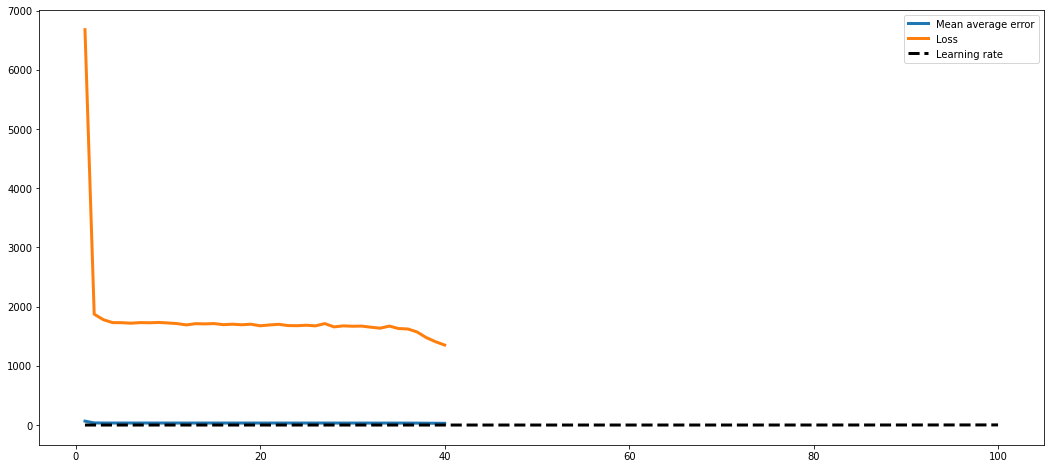

In [25]:
plt.figure(figsize= (18, 8))
plt.plot(np.arange(1, 101), initalHistory.history['mae_months'], label = 'Mean average error', lw = 3)
plt.plot(np.arange(1, 101), initalHistory.history['loss'], label = 'Loss', lw = 3)
plt.plot(np.arange(1, 101), initalHistory.history['lr'], label = 'Learning rate', lw = 3, color = '#000', linestyle = '--')
plt.legend()

In [26]:
maeNPArr = np.asarray(initalHistory.history['mae_months'])
lrNpArr = np.asarray(initalHistory.history['lr'])
lossNpArr = np.asarray(initalHistory.history['loss'])

In [27]:
maeNormalized = maeNPArr[:] * (1 / maeNPArr.max())
lrNormalized = lrNpArr[:] * (1 / lrNpArr.max())
lossNorm = lossNpArr[:] * (1 / lossNpArr.max())

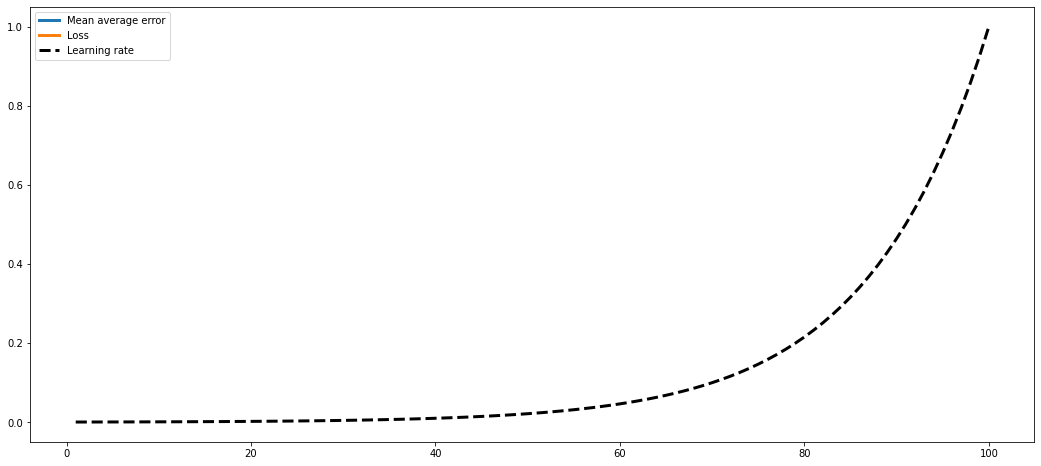

In [28]:
plt.figure(figsize= (18, 8))
plt.plot(np.arange(1, 101), maeNormalized, label = 'Mean average error', lw = 3)
plt.plot(np.arange(1, 101), lossNorm, label = 'Loss', lw = 3)
plt.plot(np.arange(1, 101), lrNormalized, label = 'Learning rate', lw = 3, color = '#000', linestyle = '--')
plt.legend()

Text(0, 0.5, 'Loss')

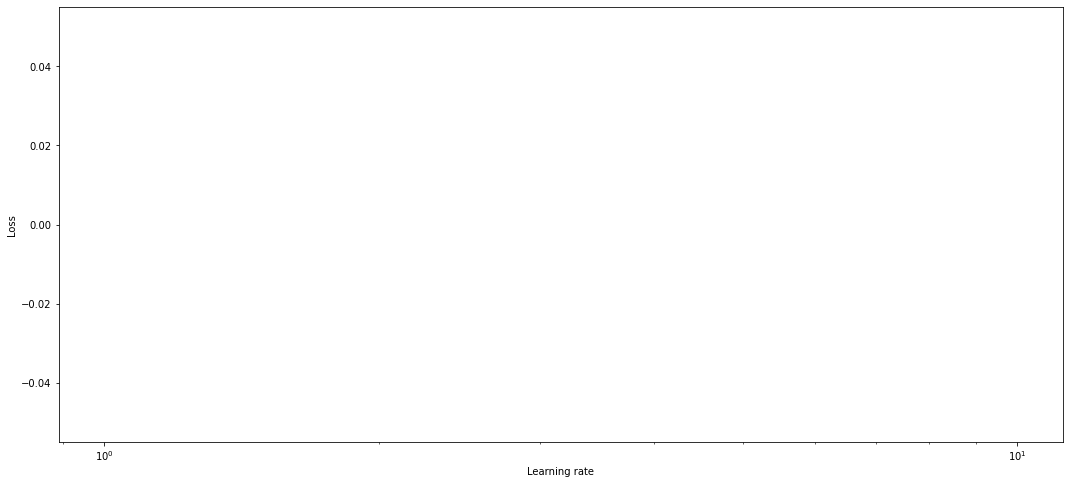

In [29]:
learning_rates = 1e-3 * (10 ** (np.arange(100) / 30))

plt.figure(figsize=(18, 8))
plt.semilogx(learning_rates, lossNorm, lw = 3, color = '#000')
plt.xlabel('Learning rate')
plt.ylabel('Loss')